In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paddy-disease-classification/sample_submission.csv
/kaggle/input/paddy-disease-classification/train.csv
/kaggle/input/paddy-disease-classification/train_images/tungro/109629.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/104765.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/109706.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/100098.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102734.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/106433.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108930.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102019.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/102416.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/101046.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/108310.jpg
/kaggle/input/paddy-disease-classification/train_images/tungro/10402

**RICE PADDY DISEASE CLASSIFICATION**

   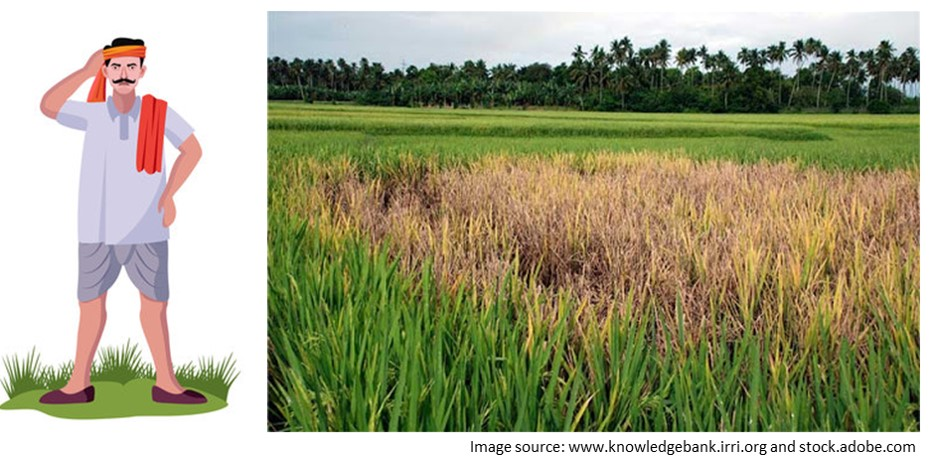

**Problem Statement**

Rice (Oryza sativa) is one of the staple foods worldwide. Paddy, the raw grain before removal of husk, is now beimg cultivated in Afrcan climates, mainly in countries like Nigeria. Paddy cultivation requires consistent supervision because several diseases and pests might affect the paddy crops, leading to up to 70% yield loss. Expert supervision is usually necessary to mitigate these diseases and prevent crop loss. With the limited availability of crop protection experts, manual disease diagnosis is tedious and expensive. Thus, it is increasingly important to automate the disease identification process by leveraging computer vision-based techniques that achieved promising results in various domains.

**Objective**

The main objective of this project is to develop a machine or deep learning-based model to classify the given paddy leaf images accurately. We have a training dataset of 10,407 labeled images across ten classes (nine disease categories and normal leaf). Moreover, also provided are additional metadata for each image, such as the paddy variety and age. The task is to be able to classify paddy images into one of the nine disease categories or a normal leaf.

**Acknowledgements**

We acknowledge the Paddy Doctor project team at the Department of Computer Science and Engineering, Manonmaniam Sundaranar University, Tirunelveli, India, and its collaborators.




**Importing Modules**

In [61]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tqdm import tqdm

# # disable all debugging logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Importing Data**

In [62]:
dir = os.listdir('../input/paddy-disease-classification')
for filenames in dir:
    print(filenames)

sample_submission.csv
train_images
train.csv
test_images


In [34]:
!cp -rf ../input/paddy-disease-classification/train_images ./train_images

In [35]:
!cp -rf ../input/paddy-disease-classification/test_images ./test_images

**Analyze Train.csv for data Insights**

In [63]:
train = pd.read_csv('../input/paddy-disease-classification/train.csv')
train.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [65]:
print(train['label'].unique())
print(train['variety'].unique())

['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']
['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']


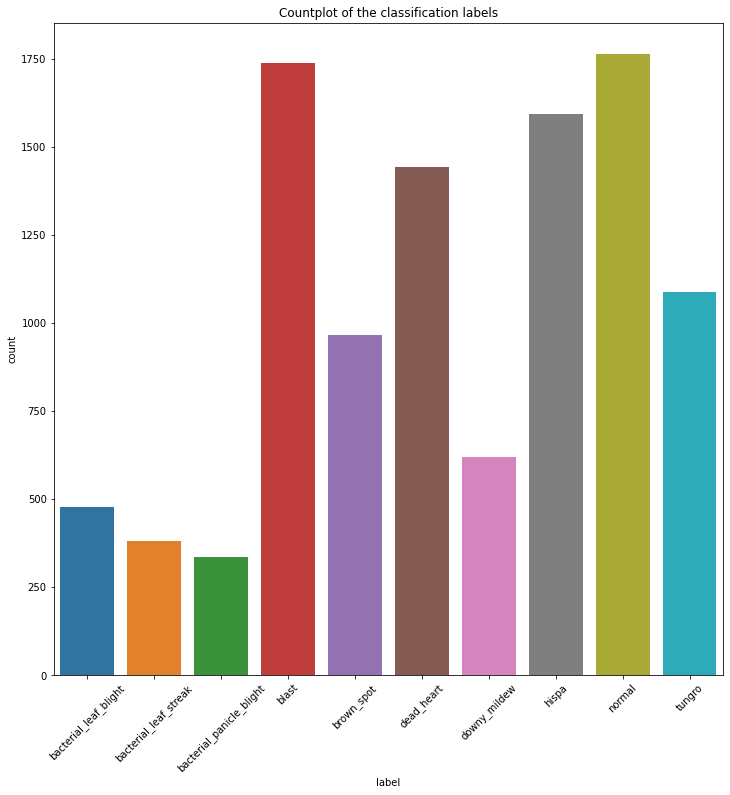

In [66]:
plt.figure(figsize=(12,12))
sns.countplot(x='label', data=train)
plt.title('Countplot of the classification labels')
plt.xticks(rotation=45)
plt.show()

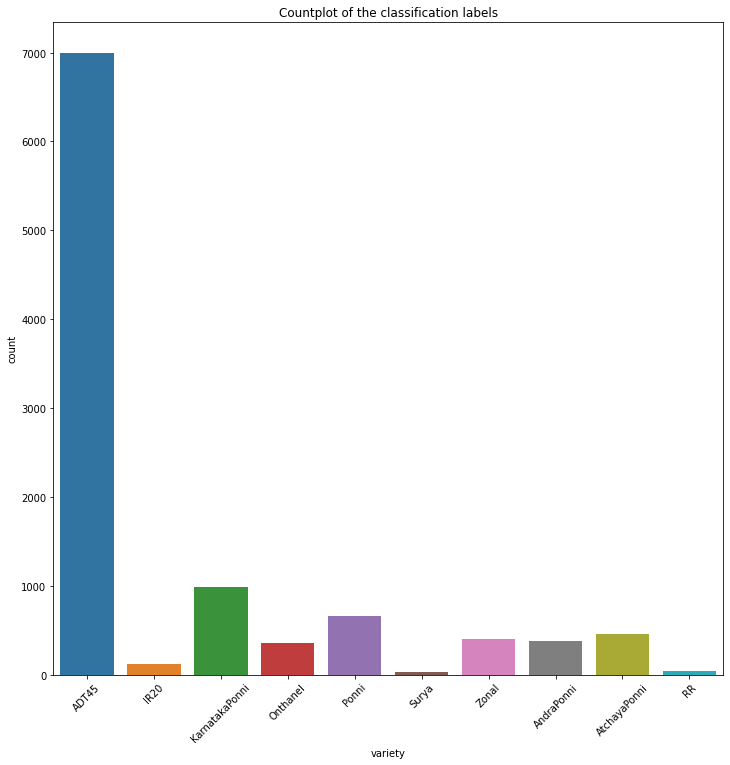

In [67]:
plt.figure(figsize=(12,12))
sns.countplot(x='variety', data=train)
plt.title('Countplot of the classification labels')
plt.xticks(rotation=45)
plt.show()

**Observations from the plots**
* In the first plot it was observed that the label column features were not evenly distributed, with blast, tungro, dead heart, hispa, normal and brown spot consisting of most ofthe data. This shows that building a model with this data will have a bias towards the more prevelant labels than the rest.
* In the second plot, it was observed that most of the image data were of ADT45 variety, which will lead to a very obvious bias to the variety.

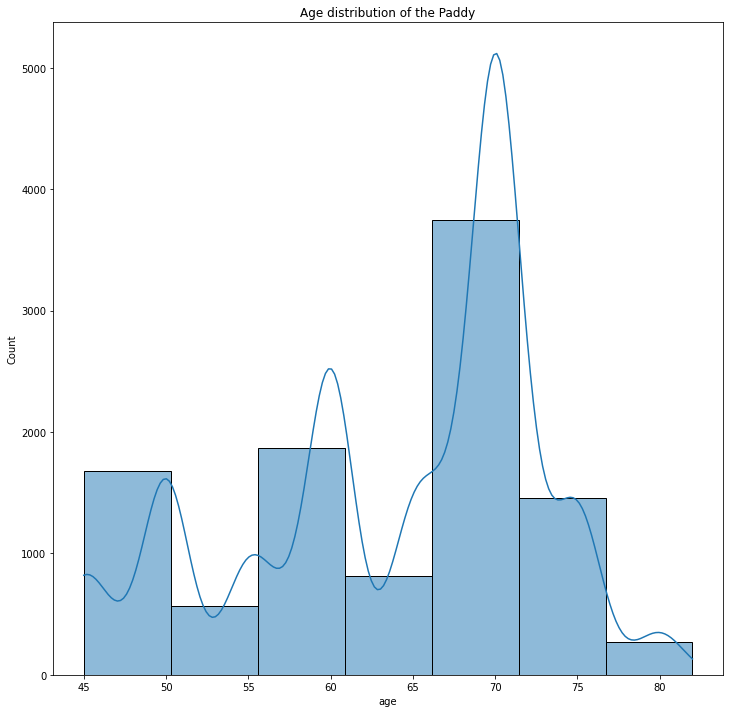

In [68]:
plt.figure(figsize=(12,12))
sns.histplot(x=train['age'], bins=7, kde=True)
plt.title('Age distribution of the Paddy')
plt.show()

The Age distribution plot above shows the distribution of the age of the paddy, with the plot resembling a trimodal distribution, having two (2) minor peaks and a major peak where a majority of the data is located. This simply means the age is spread out between three modal ranges, which have the most frequency.

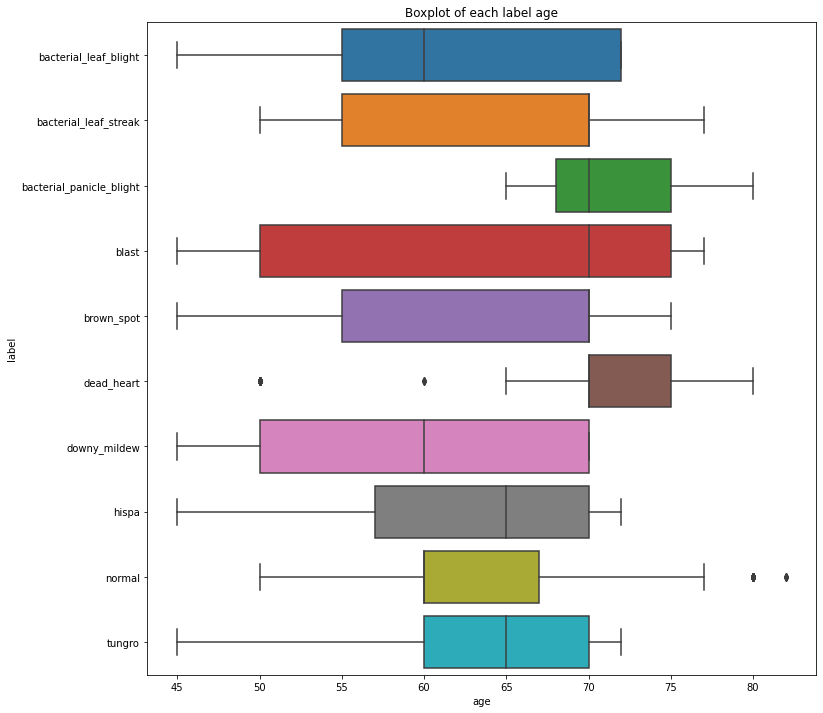

In [69]:
plt.figure(figsize=(12,12))
sns.boxplot(x='age', y='label', data=train)
plt.title('Boxplot of each label age')
plt.show()

The boxplot above shows the summary of the Interquartile range of the age feature across the labels of the data,
The plot shows the presence of outliers in the dead_heart label and the normal label (represeted by the dots) which shoulded be removed as outliers tend to affect our training process.

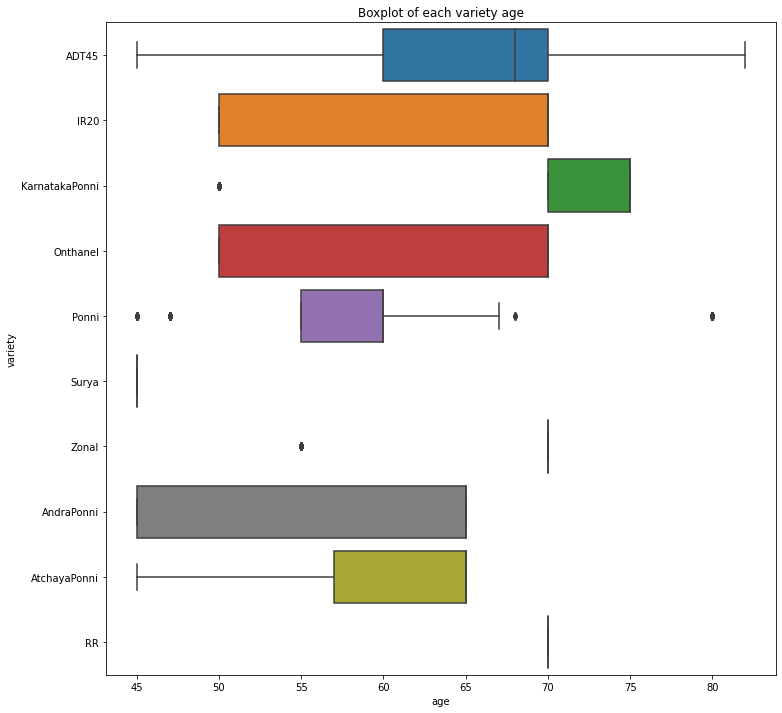

In [70]:
plt.figure(figsize=(12,12))
sns.boxplot(x='age', y='variety', data=train)
plt.title('Boxplot of each variety age')
plt.show()

This plot is similar to the above boxplot but instead of the label feature it shows the summary of the Interquartile range of the age feature across the variety feature column. 

NB: if you recall the variety column is highly populated with the ADT45 variety and hence not evenly distributed in the slightest, so most of the boxplot insights are heavily favoured towards the more populated varietys.

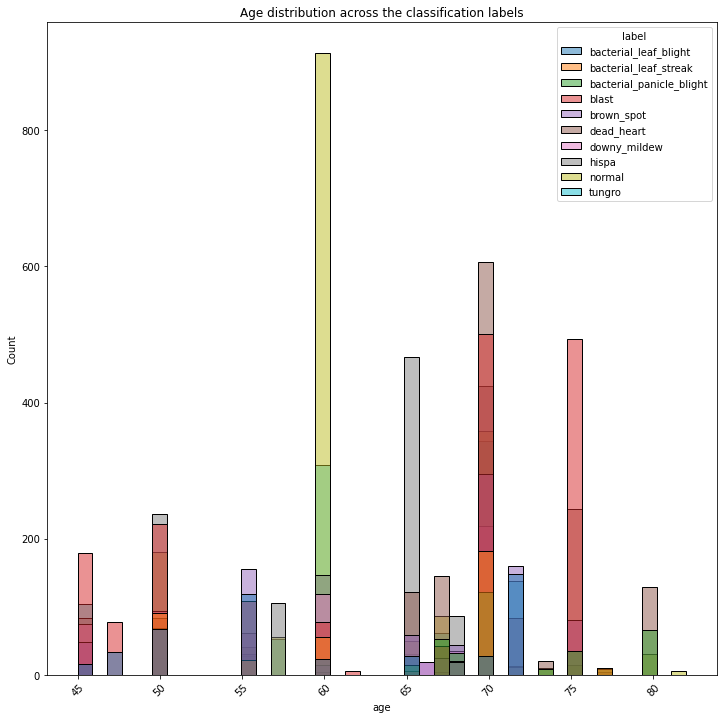

In [71]:
plt.figure(figsize=(12,12))
sns.histplot(x='age', hue='label', data=train)
plt.title('Age distribution across the classification labels')
plt.xticks(rotation=45)
plt.show()

This plot above shows the distribution of the classification labels across the age of the paddies.
A few insights can be observed at a glance, such as the absence of the normal classifiication labels between the early and later ages. Also the presence of blast in the early and late(but not latter) stages.

A similar plot with age distribution across varieties would give no significant insight as the varieties do not change with age and are set in geneology and the abundance of the ADT45 variety in the data.

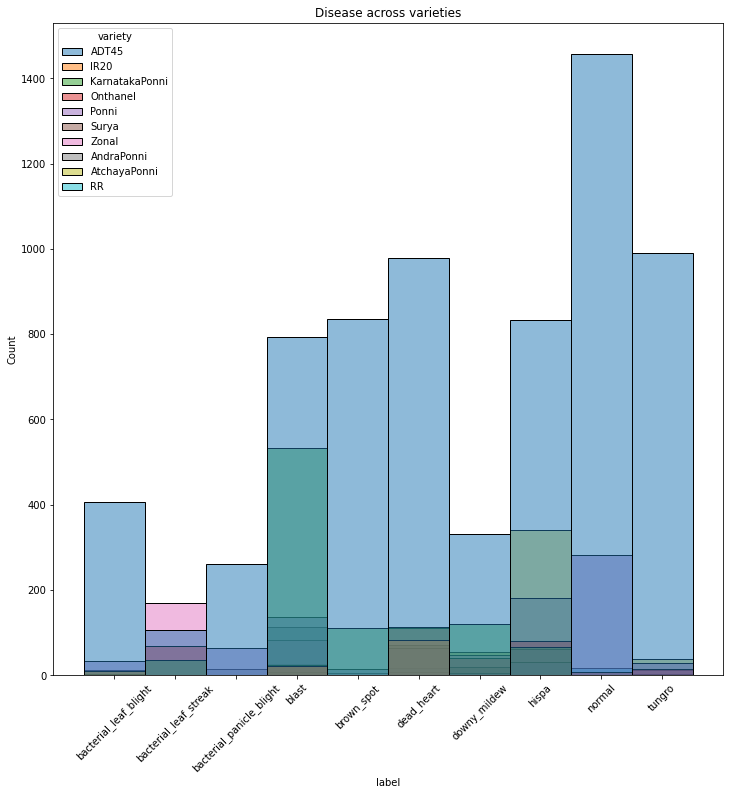

In [72]:
plt.figure(figsize=(12,12))
sns.histplot(data=train, x='label', hue='variety')
plt.title('Disease across varieties')
plt.xticks(rotation=45)
plt.show()

This plot shows the relationship between the labels and the variety features at first glance it might look redundant but if you look closer you can observe that the ADT45 variety is absent in the bacterial leaf streak classification label. Ths might prompt futher research into the label calssification and the varieties affected and not affected 

INSIGHTS FROM THE DATA

* The label classifications and varieties are not evenly distributed, which will obviously lead to bias.
* As shown in the data we will look to eliminate outliers in the normal and dead heart classifications.
* The label classifications distributions on the age column shows a correlation between the age of the plant and its healthyness as the normal classification is located within a range of age values.
* The absence of a variety in a label classification

These insights can inspire futher research to either improve the data or highlight possible biases which the model might have when predicting.

In [73]:
print(len(train[(train['label']=='dead_heart') & (train['age'] < 65)]))
print(len(train[train['label']=='dead_heart']))
# train[(train['label']=='dead_heart') & (train['age'] < 65)]

88
1442


In [74]:
print(len(train[(train['label']=='normal') & (train['age'] > 78)]))
print(len(train[train['label']=='normal']))
# train[(train['label']=='normal') & (train['age'] > 78)]

35
1764


As earlier highlighted some label clasifications in our data contain ouliers, as seen above we will like to be able to identify these images with the ouliers 

In [75]:
id = []
for index, row in train.iterrows():
    if row['label'] == 'dead_heart' and row['age'] < 65:
        id.append(row['image_id'])
    elif row['label'] == 'normal' and row['age'] > 78:
        id.append(row['image_id'])
        
print(len(id))

123


In [76]:
outlier_id = id
print(outlier_id[:11])

['101165.jpg', '102750.jpg', '108367.jpg', '109900.jpg', '100048.jpg', '100097.jpg', '100108.jpg', '100117.jpg', '100166.jpg', '100305.jpg', '100321.jpg']


****Engage the Dataset in Kaggle/Working Dir.****

In [77]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path('/kaggle/input/paddy-disease-classification/train_images/')
print(dataset_dir)

/kaggle/input/paddy-disease-classification/train_images


In [78]:
CLASS_LABELS = sorted(list(set(train['label'])))
CLASS_LABELS

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

Global Initialization of Some Variables

In [79]:
Image_Size = (680, 480)
Batch_Size = 50
Channels = 3
EPOCHS = 50

Data Pipeline Initialization

In [80]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
                                                        dataset_dir,
                                                        color_mode='rgb',
                                                        image_size=Image_Size,
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        seed=42,
                                                        batch_size=Batch_Size)

val_data =  tf.keras.preprocessing.image_dataset_from_directory(
                                                        dataset_dir,
                                                        color_mode='rgb',
                                                        image_size=Image_Size,
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        seed=42,
                                                        batch_size=Batch_Size)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [81]:
print(len(train_data))
print(len(val_data))
print(train_data)

167
42
<BatchDataset shapes: ((None, 680, 480, 3), (None,)), types: (tf.float32, tf.int32)>


In [82]:
# Exploring images in a single Batch
for images, labels in train_data.take(1):
    print(images[0].numpy())
    print(images[0].shape)
    print(labels.numpy()) 

[[[166.       206.       241.      ]
  [166.       206.       241.      ]
  [168.       206.       242.      ]
  ...
  [101.       145.        32.      ]
  [ 98.       141.        34.      ]
  [ 97.       140.        35.      ]]

 [[166.91176  205.08824  241.      ]
  [166.91176  205.08824  241.      ]
  [167.08824  205.08824  241.08824 ]
  ...
  [101.       145.        32.      ]
  [ 98.       141.        34.      ]
  [ 97.       140.        35.      ]]

 [[168.70589  205.       239.29411 ]
  [168.70589  205.       239.29411 ]
  [168.70589  205.       239.29411 ]
  ...
  [101.       145.        32.      ]
  [ 97.14706  140.14706   33.14706 ]
  [ 96.14706  139.14706   34.14706 ]]

 ...

 [[ 35.294067  85.4411     0.      ]
  [ 33.147034  83.14703    0.      ]
  [ 35.294067  79.29407    4.      ]
  ...
  [ 63.794495  99.64746    0.      ]
  [110.26483  144.26483   31.705933]
  [ 98.85297  133.70593   16.441101]]

 [[ 37.088257  88.08826    0.      ]
  [ 34.088257  84.08826    0.      ]


In [83]:
class_labels = train_data.class_names
class_labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

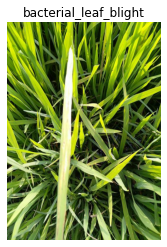

In [84]:
# Explore an Image and its Label
for image, label in train_data.take(1):            #take a single value from a batch
    plt.imshow(image[0].numpy().astype('uint8'))   #plot the numpy values of a single image in a batch
    plt.axis('off')                                 
    plt.title(class_labels[label[0].numpy()])     #show the categorical label as the title

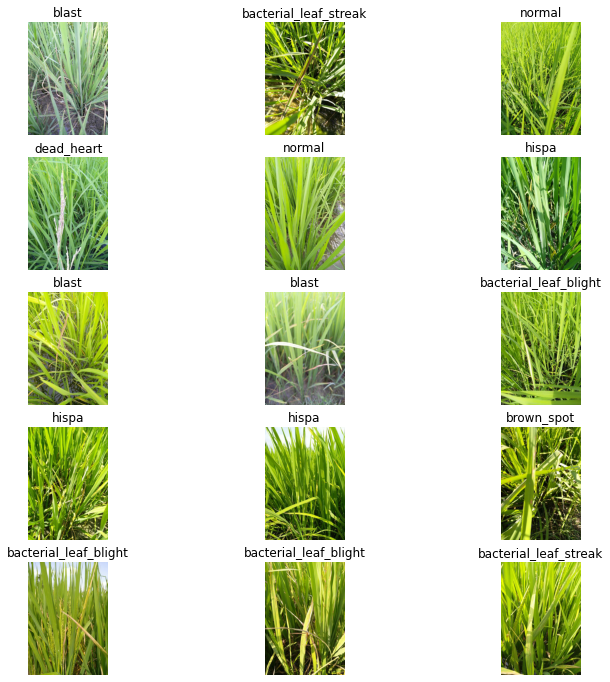

In [86]:
# Exploring Multiple Images
plt.figure(figsize=(12,12))
for image_batch, label_batch in train_data.take(1):
    for i in range(15):
        plt.subplot(5,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_labels[label_batch[i]])

**Caching,Shuffling and Prefetching the data for training Optimization**

In [87]:
train_data = train_data.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

**Image Optimization and Image Augumentation Layers**

In [88]:
# Image Preprocessing Process: Rescaling and Resizing
img_size = 250
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

Inception-V3 Model Layer

In [89]:
img_size = 250
Channels = 3
input_shape=(img_size, img_size, Channels)
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_layer = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)
inception_layer.trainable = False # Not trainable weights
inception_layer.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
______________________

Fine-Tuning Layer

In [90]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Output layer

# flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dense_layer_2 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(10, activation='softmax')

Creating First Baseline Model 

In [91]:
model0 = models.Sequential([
            resize_and_rescale, 
        data_augmentation,
        inception_layer,
        global_average_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
])

In [97]:
model0.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
history = model0.fit(
    train_data, 
    epochs = EPOCHS, 
    batch_size = Batch_Size, 
    verbose = 1, 
    validation_data = val_data,
    callbacks=early_stopping)